In [328]:
import skimage as ski
from skimage import color,io,filters,measure
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [396]:
%matplotlib inline

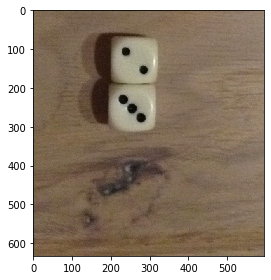

In [397]:
img = io.imread("2.png")
img = color.rgba2rgb(img)
img = ski.img_as_ubyte(img)
io.imshow(img)

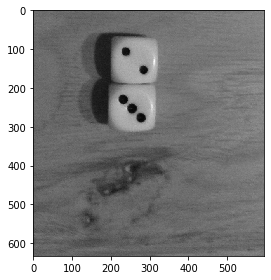

In [398]:

imgG = color.rgb2gray(img)
io.imshow(imgG)

5.6207378471050395


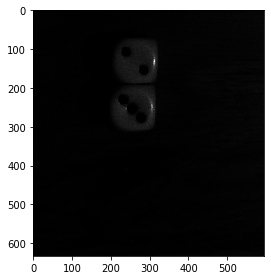

In [399]:
imgC = imgG ** ((1-np.mean(imgG))**)
print(1/np.mean(imgG)**2)
io.imshow(imgC,cmap="gray")

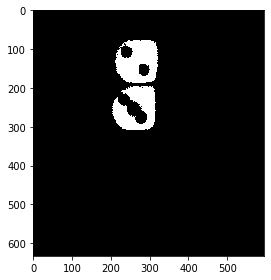

In [400]:
threshold = filters.threshold_otsu(imgC)
imgT = imgC > threshold

imgT = ski.morphology.binary_erosion(imgT)
#imgT = ski.morphology.binary_dilation(imgT)
#imgT = ski.morphology.binary_dilation(imgT)
io.imshow(imgT,cmap="gray")

5


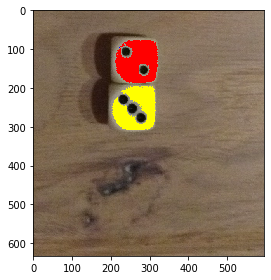

In [401]:
labelImg , n = measure.label(imgT,return_num = True,connectivity = 2)
labels = ski.img_as_ubyte(color.label2rgb(labelImg, bg_label=0))
regions = measure.regionprops(labelImg)
imgTemp = img
imgTemp[labelImg > 0] = labels[labelImg > 0]
print(n)
io.imshow(imgTemp)

2
1


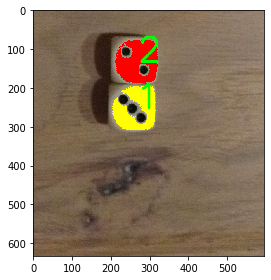

In [402]:
font = cv2.FONT_HERSHEY_SIMPLEX

for i in range(1,n+1):
    imgPom = (labelImg == i)
    neigh = np.ones((12,12))
    imgPom = ski.morphology.binary_dilation(imgPom,neigh)
    #imgPom = ski.morphology.binary_dilation(imgPom)
    #io.imshow(imgPom,cmap="gray")
    imgPom = 1-imgPom
    x, n = measure.label(imgPom,return_num = True,connectivity = 2)
    #print("test: ",n)
    if(n>1):
        print(n-1)

        y=int(regions[i-1].centroid[0])
        x=int(regions[i-1].centroid[1])
        cv2.putText(img, str(n-1), (x,y), font, 3, (0, 255, 0), 5, cv2.LINE_AA)
        
        
io.imshow(img)        

    